## Análise Exploratória dos Dados
Grupo:
- Rafael de Lima Pacheco Silva
- Carlos André Batista
- Arthur Carvalho

## Informações do Dataset
Dataset e suas informações extraídos de:
https://archive.ics.uci.edu/ml/datasets/Bach+Choral+Harmony

***
Attribute Information:
1. Choral ID: corresponding to the file names from (Bach Central).
2. Event number: index (starting from 1) of the event inside the chorale.

3-14. Pitch classes: YES/NO depending on whether a given pitch is present.
Pitch classes/attribute correspondence is as follows:
C -> 3
C#/Db -> 4
D -> 5
...
B -> 14

15. Bass: Pitch class of the bass note
16. Meter: integers from 1 to 5. Lower numbers denote less accented events,higher numbers denote more accented events.
17. Chord label: Chord resonating during the given event. 
***

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
from sklearn.preprocessing import OrdinalEncoder

plt.style.use("ggplot")
rcParams['figure.figsize'] = (12,  6)

## Visão Geral do Dataset

In [133]:
column_names = ['choral_id','event_number','C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B','bass_pitch','meter','label']
feature_cols = ['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B','bass_pitch','meter']

In [126]:
df = pd.read_csv("jsbach_chorals_harmony.data",header=None,names=column_names)

In [127]:
df.head()

,choral_id,event_number,C,C#/Db,D,D#/Eb,E,F,F#/Gb,G,G#/Ab,A,A#/Bb,B,bass_pitch,meter,label
0,000106b_,1,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,3,F_M
1,000106b_,2,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,E,5,C_M
2,000106b_,3,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,E,2,C_M
3,000106b_,4,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,3,F_M
4,000106b_,5,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,2,F_M


- O dataset contém 5665 eventos, e 17 colunas. Sendo 14 delas de features, 2 apenas de identificadores do Coral e do Evento e 1 o label do acorde a ser predito.
- Todas as features com exceção da coluna `meter` são strings, o que já mostra que será necessário utilizar alguma forma de encoding para representação delas no modelo
- Não há dados faltantes no dataset

Removendo colunas que são apenas identificadores, como o `choral_id` e `event_number`

In [128]:
df = df.drop(columns=['choral_id','event_number'])

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665 entries, 0 to 5664
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   C           5665 non-null   object
 1   C#/Db       5665 non-null   object
 2   D           5665 non-null   object
 3   D#/Eb       5665 non-null   object
 4   E           5665 non-null   object
 5   F           5665 non-null   object
 6   F#/Gb       5665 non-null   object
 7   G           5665 non-null   object
 8   G#/Ab       5665 non-null   object
 9   A           5665 non-null   object
 10  A#/Bb       5665 non-null   object
 11  B           5665 non-null   object
 12  bass_pitch  5665 non-null   object
 13  meter       5665 non-null   int64 
 14  label       5665 non-null   object
dtypes: int64(1), object(14)
memory usage: 664.0+ KB


3762 entradas do total de 5665 do dataset são dados duplicados. Isso é um comportamento esperado dada a natureza dos dados, já que um acorde tende a ser definido pela presença das mesmas frequências.

In [21]:
df.duplicated().sum()

3762

## Análise do Label

- O label conta com 102 possíveis valores categóricos, sendo assim um problema multiclasse com uma quantidade alta de classes.
- Analisando os valores dos possíveis acordes, percebe-se que existem acordes que são idênticos porém com nomenclaturas diferentes, por exemplo: G#d e Abd, isso será tratado na etapa de pré-processamento

In [34]:
df.label.nunique()

102

In [117]:
df.label.unique()

array([' F_M', ' C_M', ' D_m', ' BbM', ' C_M7', ' D_m7', ' G_M', ' A_m',
       ' C_M4', ' G_m', ' G_M7', ' D_M', ' F#d', ' AbM', ' C#d7', ' D_M7',
       ' A_M', ' EbM', ' F_M7', ' C_m', ' A_M4', ' F#m', ' B_M', ' E_M',
       ' D#d', ' C#M', ' F#m7', ' A#d', ' B_m', ' E_M7', ' E_m', ' F#M',
       ' F#M7', ' B_M7', ' A_m6', ' C#d', ' A_m7', ' A_d', ' C_m7',
       ' G_m6', ' D_M4', ' G_m7', ' E_m7', ' E_m6', ' A_M7', ' C#m',
       ' C#M7', ' A#d7', ' EbM7', ' B_m7', ' E_M4', ' C#m7', ' F_M4',
       ' D_m6', ' G#d', ' G#d7', ' A_m4', ' D_M6', ' F_d', ' B_m6',
       ' B_M4', ' C_m6', ' F_m', ' G_M4', ' F_m7', ' C_d6', ' F_m6',
       ' G_M6', ' A_M6', ' F_M6', ' F#M4', ' B_d7', ' D_d7', ' E_d',
       ' Bbm', ' Bbm6', ' DbM', ' C_d7', ' F#d7', ' Abd', ' Ebd', ' Dbd7',
       ' Dbd', ' Bbd', ' Dbm7', ' Abm', ' DbM7', ' Dbm', ' F#m6', ' G#m',
       ' B_d', ' C_M6', ' D#m', ' D#M', ' BbM7', ' F_d7', ' C#d6', ' G_d',
       ' G#M', ' C#M4', ' D#d6', ' D#d7'], dtype=object)

O alto número de classe eleva bastante a complexidade do problema, além disso as classes estão bastante desbalanceadas como mostra o gráfico de frequências abaixo. 

Isso já indica que as classes não terão boa separabilidade e que será necessário avaliar o desempenho de algoritmos de balanceamento de classes para o treinamento do modelo.

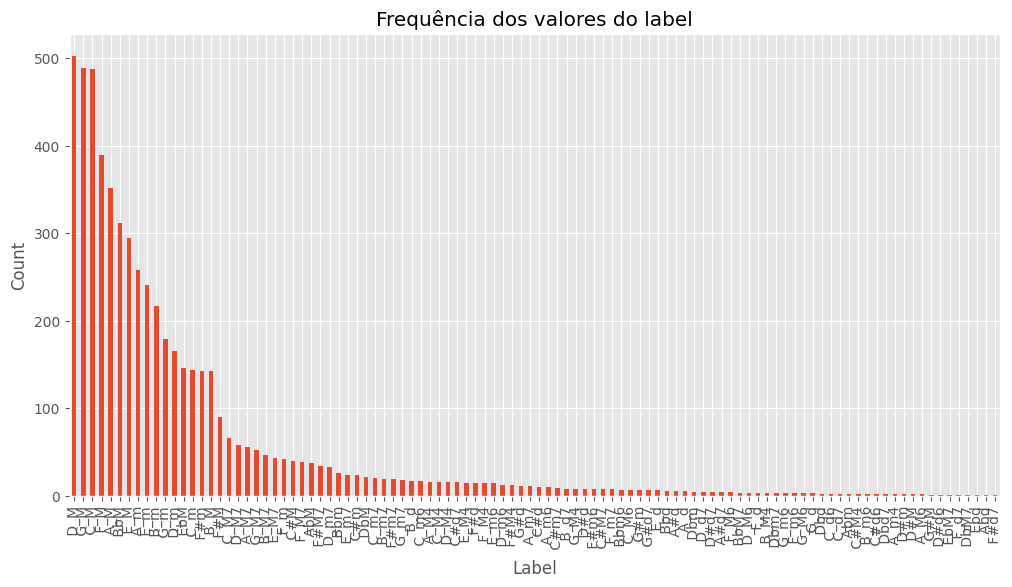

In [33]:
df.label.value_counts().plot(kind="bar")
plt.title("Frequência dos valores do label")
plt.xlabel("Label")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.show()

Como os dados do label são categóricos, para o pré-processamento será necessário utilizar o `OrdinalEncoder` do scikit-learn ou similar.

## Análise das Features

Para as análises das features, será realizado o encoding das variáveis categóricas para que seja possível realizar análises de correlação, distribuição, etc.

- Para as features de frequência (YES|NO), os dados serão convertidos em valores binários 1 e 0, respectivamente
- Para a feature bass_pitch será atribuido um valor ordinal para cada uma dos 16 possíveis valores. No bass_pitch também há a ocorrência de notas idênticas com nomes diferentes, que será tratada no pré-processamento.
- A feature meter não sofrerá alteração pois já está no formato `int`
- Será feito um encoding do target para um valor ordinal para cada um dos 102 possíveis valores.

In [134]:
encoder = OrdinalEncoder()

In [135]:
encoded_df = pd.DataFrame(encoder.fit_transform(df),columns=feature_cols+['label'])

In [136]:
encoded_df.head()

,C,C#/Db,D,D#/Eb,E,F,F#/Gb,G,G#/Ab,A,A#/Bb,B,bass_pitch,meter,label
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0,2.0,81.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,4.0,35.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,1.0,35.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0,2.0,81.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0,1.0,81.0


In [137]:
encoded_df.describe()

,C,C#/Db,D,D#/Eb,E,F,F#/Gb,G,G#/Ab,A,A#/Bb,B,bass_pitch,meter,label
count,5665.000000,5665.000000,5665.000000,5665.000000,5665.000000,5665.000000,5665.000000,5665.000000,5665.000000,5665.000000,5665.000000,5665.000000,5665.000000,5665.000000,5665.000000
mean,0.315975,0.168402,0.417476,0.125154,0.375110,0.226655,0.249250,0.378111,0.116328,0.419241,0.180229,0.316152,7.830009,2.134863,50.304501
std,0.464944,0.374256,0.493186,0.330923,0.484194,0.418704,0.432617,0.484958,0.320647,0.493478,0.384412,0.465014,4.675020,1.109710,29.955009
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,22.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,2.000000,49.000000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,12.000000,3.000000,78.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,4.000000,101.000000


A análise geral de frequências pode indicar o campo harmônico mais utilizado pelo compositor, o que pode facilitar a definição de um acorde em casos de incerteza. Pois na dúvida entre um acorde não identificado, pode ser priorizado um acorde que pertence ao campo harmônico, ou seja, que é feito com as notas mais frequentes.

Text(0.5, 1.0, 'Frequência das notas em todo o dataset')

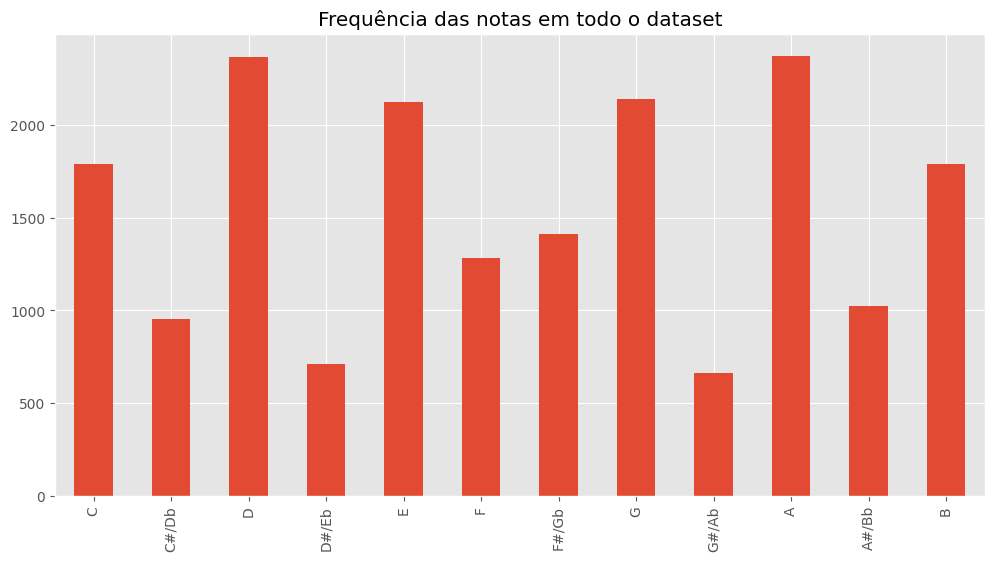

In [158]:
encoded_df[['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']].sum().plot(kind='bar')
plt.title('Frequência das notas em todo o dataset')

Apesar da alta quantidade de classes, que eleva a complexidade e diminui sua separabilidade, analisando as frequências que as notas ocorrem em cada classe, percebe-se que algumas notas são mais frequentes para cada classe, o que pode indicar certo nível de separabilidade.

<AxesSubplot:xlabel='label'>

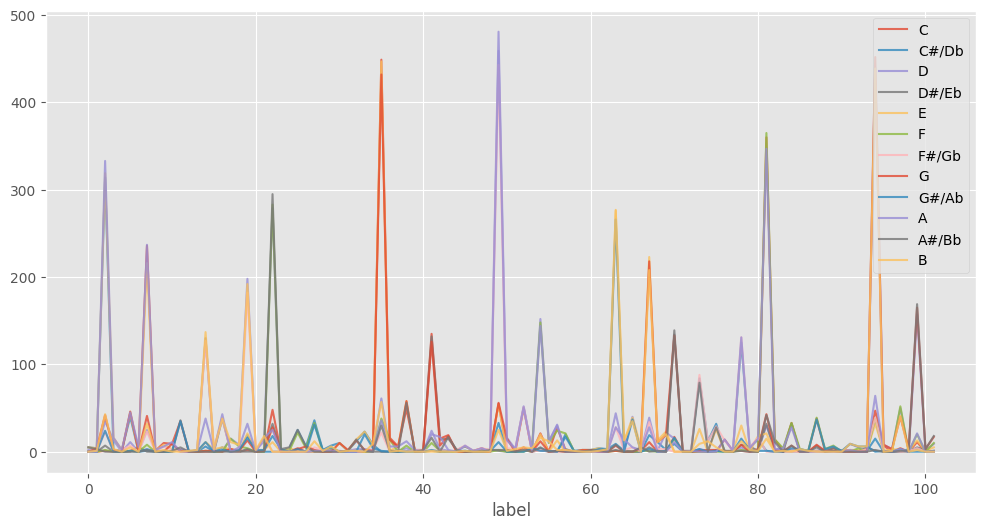

In [160]:
encoded_df.groupby('label')[['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']].sum().plot(alpha=0.8)

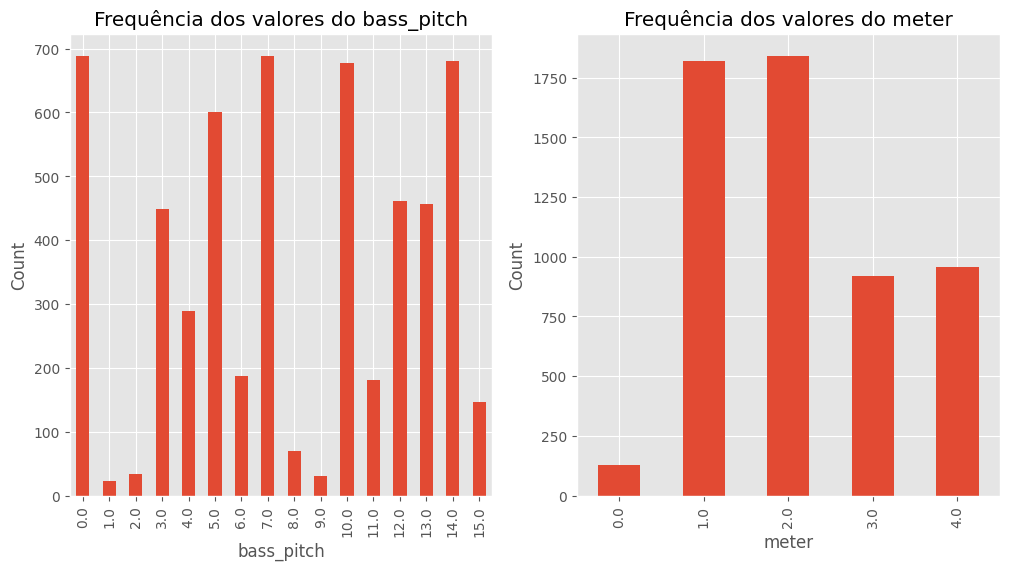

In [112]:
fig, (ax1,ax2) = plt.subplots(1,2)
encoded_df.bass_pitch.value_counts().sort_index().plot(kind="bar",ax=ax1)
ax1.set_title("Frequência dos valores do bass_pitch")
ax1.set_xlabel("bass_pitch")
ax1.set_ylabel("Count")

encoded_df.meter.value_counts().sort_index().plot(kind="bar",ax=ax2)
ax2.set_title("Frequência dos valores do meter")
ax2.set_xlabel("meter")
ax2.set_ylabel("Count")

plt.show()